# Vertex Model Grid (DISV) plotting 

No problem! Flopy supports vertex model grid plotting through the `PlotMapView` and `PlotCrossSection` classes. 

The method calls are almost identical to models that use a Structured Model Grid (DIS) to define the model discretization and the same keyword arguments are supported. Let's run through an example using a vertex model grid.

First let's import flopy and get the model loaded!

In [1]:
import os
import sys

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.plot import PlotMapView, PlotCrossSection
    from flopy.utils import HeadFile, CellBudgetFile, geometry
    from flopy.discretization import VertexGrid
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
    from flopy.plot import PlotMapView, PlotCrossSection
    from flopy.utils import HeadFile, CellBudgetFile, geometry
    from flopy.discretization import VertexGrid
      
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))  

flopy is installed in /Users/jdhughes/Documents/Development/flopy_git/flopy_fork/flopy
3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 14:38:56) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version: 1.17.3
matplotlib version: 3.1.1
flopy version: 3.2.13


In [2]:
# load up the example problem
sim_name = "mfsim.nam"
sim_path = "../data/mf6/test003_gwftri_disv"
sim = flopy.mf6.MFSimulation.load(sim_name=sim_name, version="mf6", exe_name="mf6",
                                  sim_ws=sim_path)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package chd...
    loading package oc...
  loading ims package gwf_1...


Now let's check the model name and then get an instance of our model

In [3]:
sim.model_names

odict_keys(['gwf_1'])

In [4]:
ml = sim.get_model('gwf_1')
ml

name = gwf_1
model_type = gwf
version = mf6
model_relative_path = 

###################
Package disv
###################

package_name = disv
filename = tri_model_cnst.disv
package_type = disv
model_or_simulation_package = model
model_name = gwf_1


###################
Package ic
###################

package_name = ic
filename = tri_model.ic
package_type = ic
model_or_simulation_package = model
model_name = gwf_1


###################
Package npf
###################

package_name = npf
filename = tri_model.npf
package_type = npf
model_or_simulation_package = model
model_name = gwf_1


###################
Package chd_left
###################

package_name = chd_left
filename = tri_model_left.chd
package_type = chd
model_or_simulation_package = model
model_name = gwf_1


###################
Package chd_right
###################

package_name = chd_right
filename = tri_model_right.chd
package_type = chd
model_or_simulation_package = model
model_name = gwf_1


###################
Package o

## Get the `VertexModelGrid` object
The `VertexModelGrid` is integrated into flopy and can be called by using the `.modelgrid` attribute on their model object

In [5]:
vmg = ml.modelgrid
vmg.set_coord_info(angrot=-25)
vmg

xll:0.0; yll:0.0; rotation:-25; units:undefined; lenuni:0

Now all the discretization information is available to be used to plot model data in a `PlotMapView` or `PlotCrossSection` object

Let's begin with `PlotMapView` and plot the model grid.

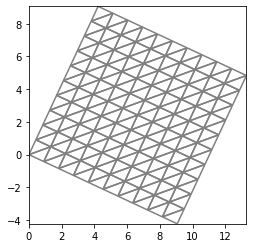

In [6]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_grid()

As we can see, the model grid plots as a series of grid lines.

We can also plot inactive cells using `plot_inactive`

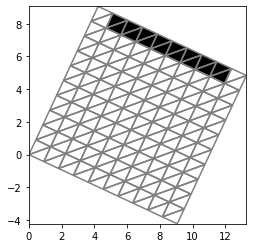

In [7]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_inactive()
vmap.plot_grid();

Model data can be plotted using the `plot_array` method as follows:

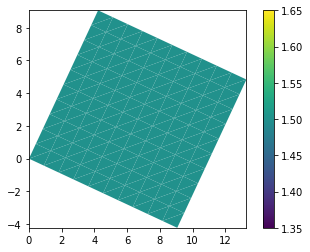

In [8]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_array(a=ml.dis.botm.array)
plt.colorbar(ax);

This plot shows the bottom elevations of layer 1. These are a constant value of 1.5 in this example.

Let's import some data from the model output to use with `plot_array()` to illustrate plotting better.

In [9]:
hds_file = os.path.join(sim_path, "tri_model.hds")
cbc_file = os.path.join(sim_path, "tri_model.cbc")

hds = HeadFile(hds_file)
hdata = hds.get_alldata()[0]
hdata.shape = (4, -1)

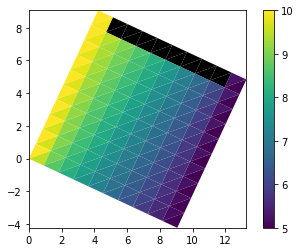

In [10]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_inactive()
ax = vmap.plot_array(a=hdata.ravel(), masked_values=[1e30])
plt.colorbar(ax);

Data can also be contoured using the `contour_array` method.

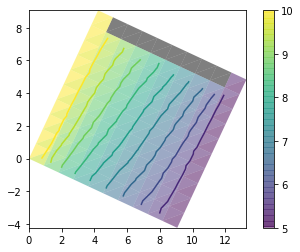

In [11]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_inactive(alpha=0.5)
ax = vmap.plot_array(a=hdata[0], masked_values=[1e30], alpha=0.5)
levels = np.arange(5, 10, 0.5)
vmap.contour_array(a=hdata[0], masked_values=[1e30], levels=levels)
plt.colorbar(ax);

Print the head at specific coordinates.

In [12]:
icell2d = vmg.intersect(8.,-1.)
print('The head in layer 1 at x = 8, y = -1 is {}'.format(hdata[0,icell2d]))

The head in layer 1 at x = 8, y = -1 is 6.0835322997028625


### Plotting specific discharge

In modflow 6 SAVE_SPECIFIC_DISCHARGE can be specified in the NPF package option block. 

Here we grad the specific discharge recarray and use it to plot discharge vectors using FloPy

In [13]:
cbc = CellBudgetFile(cbc_file, precision='double')
spdis = cbc.get_data(text="SPDIS")
len(spdis[0])

784

Now we can pass the specific discharge recarray to `plot_specific_discharge`; FloPy will create a quiver plot of the discharge vectors

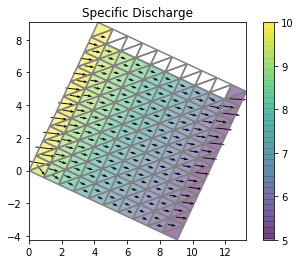

In [14]:
vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_grid()
ax = vmap.plot_array(a=hdata, alpha=0.5, masked_values=[1e30])
plt.colorbar(ax)
ax = vmap.plot_specific_discharge(spdis[0])
plt.title("Specific Discharge");

# Working with model cross sections

Flopy supports cross sections for vertex model grids, similarly to structured model grids by using the `PlotCrossSection` class. In fact most of the functionality is identical to `PlotCrossSection` with a Structured model grid. 

### Note:
Cross sections must be defined by a line, since there is no row or column in a vertex model grid.

Let's start by creating our cross section line and showing it on a `PlotMapView` object. 

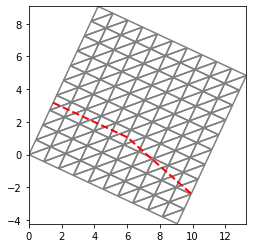

In [15]:
# define a line through the model in model coordiantes as a 
# series of XY vertices where the cross section will be sliced!
line = np.array([(0,3.5), (5, 3.5), (10.1, 2)])

# Transform the line into the spatial refenernce projection to match the projected coordiates
line = geometry.transform(line.T[0], line.T[1], 
                           vmg.xoffset, vmg.yoffset, 
                           vmg.angrot_radians)

vmap = PlotMapView(modelgrid=vmg, layer=0)
ax = vmap.plot_grid()
plt.plot(line[0], line[1], 'r--', linewidth=2);

Now that we see our cross section line traverses the simulation domain where we were expecting it, let's create a cross section using the `PlotCrossSection` and plot the model grid using `plot_grid`

Our cross section line is passed to the `line` dictionary

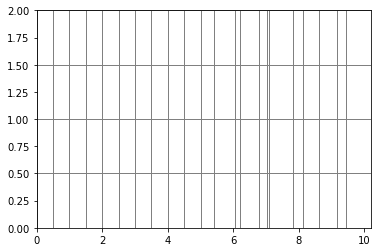

In [16]:
line = np.array(line).T

vcs = PlotCrossSection(modelgrid=vmg, line={"line": line})
vcs.plot_grid();

Array data can be plotted over similarly to the `PlotMapView` example by calling the `plot_array` method.

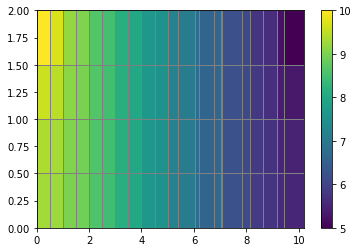

In [17]:
vcs = PlotCrossSection(modelgrid=vmg, line={"line": line})

ax = vcs.plot_array(a=hdata, masked_values=[1e30])
plt.colorbar(ax)
vcs.plot_grid();

Contour plots can also be made using the `contour_array()` method. 

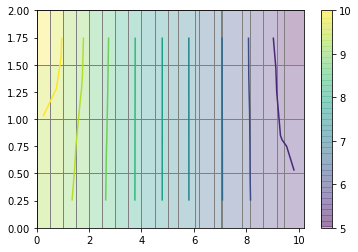

In [18]:
vcs = PlotCrossSection(modelgrid=vmg, line={"line": line})

ax = vcs.plot_array(a=hdata, masked_values=[1e30], alpha=0.3)
plt.colorbar(ax)
# set our own contour levels using the matplotlib keyword argument levels
levels = np.arange(5, 10, 0.5)
vcs.contour_array(a=hdata, masked_values=[1e30], levels=levels)
vcs.plot_grid();

## Plotting discharge

Discharge is plotted similarly to the previous example:

The SPDIS recarray is used with `plot_specific_discharge` to create and plot flow vectors

### Note:
Arbitrary cross section lines cannot be used with this method. A straight cross section must be supplied to calculate discharge vectors.

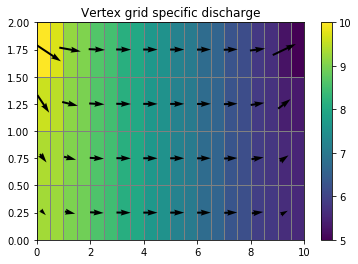

In [19]:
# Added 0.01 to 10 to account for precision issues with transforms...
line = np.array([(-0.1, 3.5), (10.1, 3.5)])

# Transform the line into the spatial refenernce projection to match the projected coordiates
line = geometry.transform(line.T[0], line.T[1], 
                          vmg.xoffset, vmg.yoffset, 
                          vmg.angrot_radians)
line = np.array(line).T

vcs = PlotCrossSection(modelgrid=vmg, line={"line": line})
ax = vcs.plot_array(a=hdata, masked_values=[1e30])
plt.colorbar(ax)
vcs.plot_grid()
# use hstep to plot every second cell in the horizontal direction
ax = vcs.plot_specific_discharge(spdis[0], head=hdata, hstep=2)
plt.xlim([0, 10])
plt.title("Vertex grid specific discharge");

The discharge vectors look a little crammed due to the triangular nature of the grid 

### Let's load up a square grid example and plot up discharge vectors.

In [20]:
sim_name = "mfsim.nam"
sim_path = "../data/mf6/test003_gwfs_disv"
sim = flopy.mf6.MFSimulation.load(sim_name=sim_name, version="mf6", exe_name="mf6",
                                  sim_ws=sim_path)
sim.run_simulation()

ml = sim.get_model('gwf_1')
vmg = VertexGrid(ml.dis.vertices.array, ml.dis.cell2d.array,
                 top=ml.dis.top.array, botm=ml.dis.botm.array,
                 idomain=ml.dis.idomain.array, xoff=10,
                 yoff=0, angrot=-25)

cbc_file = os.path.join(sim_path, "model.cbc") #"expected_output/", "model_unch.cbc")
hds_file = os.path.join(sim_path, "model.hds") # "expected_output/", "model_unch.hds")

cbc = CellBudgetFile(cbc_file, precision='double')
spdis = cbc.get_data(text="SPDIS")

hds = HeadFile(hds_file)
hdata = hds.get_alldata()[0]
hdata.shape = (4, -1)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package chd...
    loading package oc...
  loading ims package gwf_1...
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 19 2019 16:46:21 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and

Now let's plot the discharge vectors for a model with a grid of uniform elevations

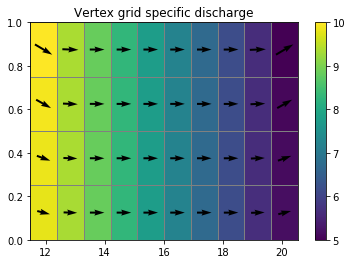

In [21]:
# Added 0.01 to 10 to account for precision issues with transforms...
line = np.array([(-0.1, 3.5), (10.1, 3.5)])

# Transform the line into the spatial refenernce projection to match the projected coordiates
line = geometry.transform(line.T[0], line.T[1], 
                          vmg.xoffset, vmg.yoffset, 
                          vmg.angrot_radians)
line = np.array(line).T

vcs = PlotCrossSection(modelgrid=vmg, line={"line": line}, geographic_coords=True)
ax = vcs.plot_array(a=hdata, masked_values=[1e30])
plt.colorbar(ax)
vcs.plot_grid()
ax = vcs.plot_specific_discharge(spdis[0], head=hdata)
plt.title("Vertex grid specific discharge");

These discharge vectors are much more uniform as expected.

### For more information about the plotting functionality in flopy including optional keyword arguments, please see the ipython notebook: flopy3_PlotArrayExample.ipynb, flopy3_PlotMapView_demo.ipynb, and flopy3_PlotCrossSection_demo.ipynb

### Happy plotting!